# Setup





In [0]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Navigate to folder containing project
import os
os.chdir("drive/My Drive/COMP 551/Projects/Project3")

In [0]:
from google.colab.patches import cv2_imshow
# Function to show a single image 
def show_single_picture(img):
    """ Plot an image """
    cv2_imshow(img*255)

# VGG16


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import datetime
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.model_selection import train_test_split

# Using pre-trained models
from keras.applications import VGG16, VGG19, InceptionResNetV2, Xception, NASNetLarge
from keras import datasets, optimizers
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
# Read data 
x_train = pd.read_pickle("data/x_train.pkl")
x_valid = pd.read_pickle("data/x_valid.pkl")
y_train = pd.read_pickle("data/y_train.pkl")
y_valid = pd.read_pickle("data/y_valid.pkl")

# Convert training/valid images from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)
x_valid = np.stack((x_valid,x_valid,x_valid), axis=-1)

# Image dimensions 
image_size = x_train[0].shape[0]
num_channels = x_train[0].shape[2]
print("Image size: {0}\nNumber of channels: {1}".format(image_size, num_channels))

Image size: 128
Number of channels: 3


**The goal when applying data augmentation is to increase the generalizability of the model.**
Given that our network is constantly seeing new, slightly modified versions of the input data, the network is able to learn more robust features.

Reasons to use a data generator
- Real-world datasets are often too large to fit into memory.
- They also tend to be challenging, requiring us to perform data augmentation to avoid overfitting and increase the ability of our model to generalize.

Here's how the ImageDataGenerator works:
1. Accepting a batch of images used for training.
2. Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
3. Replacing the **original** batch with the **new, randomly transformed batch**.
4. Training the CNN on this randomly transformed batch (i.e., the original data itself is not used for training).

Keras' ImageDataGenerator executes in-place data augmentation. 
It is called "in-place" and "on-the-fly", because data augmentation is done at training time. 
If we included the original training data along with the augmented data in each batch, then the network would “see” the original training data multiple times, effectively defeating the purpose.
The entire point of the data augmentation technique described in this section is to ensure that the network sees “new” images that it has never "seen" before at each and every epoch.
To accomplish this goal we “replace” the training data with randomly transformed, augmented data.
Performing data augmentation is a form of regularization, enabling our model to generalize better. 

NOTE: we don't apply data augmentation to validation/test data, therefore we don't need a generator.

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [0]:
# Construct the training image generator to perform data augmentation (NOTE: since we are working numbers, it is important to set the rotation and the horizontal_flip to 0 and False respectively).
datagen = ImageDataGenerator(rotation_range=0, zoom_range=0.10,
	width_shift_range=0.05, height_shift_range=0.05, shear_range=0,
	horizontal_flip=False,vertical_flip=False, fill_mode="nearest")

In [0]:
# Fit data generator on training data for ZCA whitening
datagen.fit(x_train)

In [0]:
# Verify image generated by ImageDataGenerator
for i in  datagen.flow(x=x_train,y=y_train)[0][0]:
  show_single_picture(i)

In [0]:
# Initialize number of epochs, batch_size and validation split 
WARMUP = 10
EPOCHS = 30
batch_size = 256

In [0]:
# Initialize optimizer
learning_rate = 5e-4
optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9) 

# Handmade Model

In [0]:
def create_model():
    """ Function that returns a model """
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3,3), input_shape=(image_size, image_size, num_channels),activation='relu', data_format="channels_last"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu', data_format="channels_last"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))
    model.add(layers.Conv2D(64, (3,3), activation='relu', data_format="channels_last"))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))
    model.add(layers.Conv2D(32, (3,3), activation='relu', data_format="channels_last"))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.20))
    model.add(layers.Dense(10, activation='softmax'))
    
    # Print a summary of the model
    model.summary()

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

def predict(model):
    """ Method that takes as input a pretrained model """
    # Read test data 
    x_test = pickle.load(open('preprocessed_test_max_x.pkl', 'rb'))

    # Reshape test 
    x_test = x_test.reshape(x_test.shape[0],128,128,1)
    
    # Predict
    predictions = model.predict(x_test)
    print(predictions)
    
    # Store predictions
    pickle.dump(predictions, open("predictions{}.pkl".format(datetime.datetime.now()),"wb"))
    
def plot_accuracy(history):
  plt.figure(figsize=(15,15))
  plt.plot(history.history['acc'], label='accuracy')
  plt.plot(history.history['val_acc'], label = 'val_accuracy')
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.ylim([0.5,1])
  plt.legend(loc=0)
  plt.savefig("plots/train_val_accuracy{}.png".format(datetime.datetime.now()))
  plt.show()

In [0]:
# Save the model
model.save('models/CNN_{}_4DC_sgd_learning_rate{}.h5'.format(max(history.history['val_acc']), learning_rate))

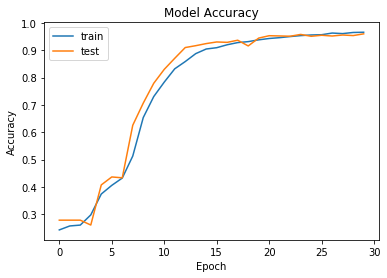

In [0]:
# Plot history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/CNN_accuracy.png')
plt.show()

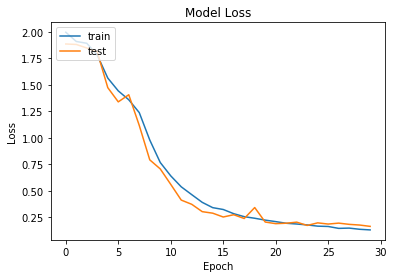

In [0]:
# Plot history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('plots/CNN_loss.png')
plt.show()

In [0]:
# Load full dataset to train final model 
x_train = pd.read_pickle("data/preprocessed_train_max_x.pkl")
y_train = pd.read_csv("data/train_max_y.csv")["Label"]

# Transform data from grayscale to rgb (3 channels)
x_train = np.stack((x_train,x_train,x_train), axis=-1)

# Load final model
from keras.models import load_model
model = load_model("models/cnn.h5")

# Fit on entire dataset
history = model.fit_generator(datagen.flow(x=x_train, y=y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, epochs=EPOCHS)

Epoch 1/30
195/195 [==============================] - 133s 682ms/step - loss: 0.0737 - acc: 0.9841
Epoch 2/30
195/195 [==============================] - 129s 664ms/step - loss: 0.0685 - acc: 0.9842
Epoch 3/30
195/195 [==============================] - 130s 667ms/step - loss: 0.0621 - acc: 0.9856
Epoch 4/30
195/195 [==============================] - 130s 668ms/step - loss: 0.0617 - acc: 0.9857
Epoch 5/30
195/195 [==============================] - 129s 662ms/step - loss: 0.0589 - acc: 0.9859
Epoch 6/30
195/195 [==============================] - 130s 668ms/step - loss: 0.0539 - acc: 0.9864
Epoch 7/30
195/195 [==============================] - 130s 667ms/step - loss: 0.0529 - acc: 0.9871
Epoch 8/30
195/195 [==============================] - 129s 664ms/step - loss: 0.0515 - acc: 0.9874
Epoch 9/30
195/195 [==============================] - 130s 666ms/step - loss: 0.0507 - acc: 0.9878
Epoch 10/30
195/195 [==============================] - 129s 663ms/step - loss: 0.0503 - acc: 0.9878
Epoch 11/

In [0]:
# Save final model 
model.save('models/CNN.h5')

In [0]:
def predict(model):
  """Method that takes as input a model and stores its predictions in a csv file."""
  import datetime

  test_img = pd.read_pickle("data/preprocessed_test_max_x.pkl")

  # Convert tests images from grayscale to rgb (3 channels)
  test_img = np.stack((test_img,test_img,test_img), axis=-1)

  # Predict 
  preds = model.predict(test_img).argmax(axis=-1)

  # Create DataFrame with predictions
  df = pd.DataFrame({"Id": list(range(len(preds))), "Label": preds})

  # Save predictions 
  df.to_csv("predictions/predictions{}.csv".format(datetime.datetime.now()), index=False)

  return preds 